# 期末综合练习（2）

### 对keras内置路透社文本数据集进行内容分类（要求模型至少包含有两要素：CNN 、 RNN、 注意力机制）
即：Conv + RNN 或RNN + 注意力机制 或 CNN + 注意力机制
路透社数据集：<BR>
路透社数据集包含许多短新闻及其对应的主题，由路透社在1986年发布。包括46个不同的主题，其中某些主题的样本更多，但是训练集中的每个主题都有至少10个样本。<BR>
与IMDB数据集一样，路透社数据集也内置到了Keras库中，并且已经经过了预处理。<BR>
#### 提示：
由于文本较长，先用CNN卷积上采样到较短长度，再用RNN处理是一个避免梯度消失的方案。<BR>
    (由于卷积核为一维，卷积核大小要相应增大到5或7，stride增加到3或5)。<BR>
引入注意力机制是另一种克服遗忘的方案。<BR>
采用pytorch框架的同学，也利用keras读取数据集内容后进行训练
#### 要求：
利用callback将最佳模型保存到文件(注意：在"save"目录下建立以自己学号命名的子目录，然后在该子目录下保存文件)，
最后对最佳模型进行指标评估，展示混淆矩阵
#### 数据读取方法：
(x_train, y_train), (x_test, y_test) = keras.datasets.reuters.load_data(num_words=10000, test_split=0.2)

#### 考核办法：
1）程序功能完成度<BR>
2）计算得到的准确率为指标，准确率达到0.7为及格成绩起点，0.8以上优秀<BR>
score = model.evaluate(x_test, y_test)


In [1]:
#首先执行GPU资源分配代码，勿删除。
import GPU
GPU.show()
GPU.alloc(0,1024)

Sun Jun 25 19:35:52 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 45%   42C    P8    33W / 350W |   8806MiB / 24268MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:03:00.0 Off |                  N/A |
| 62%   

In [2]:
import numpy as np

from sklearn.metrics import accuracy_score
from tensorflow.keras.datasets import reuters
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [3]:
# parameters for data load
num_words = 10000
maxlen = 50
test_split = 0.2

In [4]:
# np_load_old = np.load

# # modify the default parameters of np.load
# np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

In [5]:
(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words = num_words, maxlen = maxlen, test_split = test_split)
print(y_train.shape)
print(y_test.shape)

(1595,)
(399,)


In [6]:
# pad the sequences with zeros 
# padding parameter is set to 'post' => 0's are appended to end of sequences
X_train = pad_sequences(X_train, padding = 'post')
X_test = pad_sequences(X_test, padding = 'post')

X_train = np.array(X_train).reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = np.array(X_test).reshape((X_test.shape[0], X_test.shape[1], 1))

y_data = np.concatenate((y_train, y_test))
y_data = to_categorical(y_data)
y_train = y_data[:1595]
y_test = y_data[1595:]
print(y_train.shape)

(1595, 46)


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Activation,Input , Lambda,Dot,Attention
from tensorflow.keras import optimizers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

def deep_lstm():
    inputs = Input(shape=(49, 1))
    lstm1 = LSTM(20, return_sequences=True)(inputs)
    lstm2 = LSTM(20, return_sequences=True)(lstm1)
    lstm3 = LSTM(20, return_sequences=True)(lstm2)
    
   # Apply attention to the output of the third LSTM layer
    attention = Attention()([lstm3, lstm3])
    
    lstm4 = LSTM(20, return_sequences=False)(attention)
    
    
    dense = Dense(46)(lstm4)
    outputs = Activation('softmax')(dense)

    model = Model(inputs=inputs, outputs=outputs)

    adam = optimizers.Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

    return model

In [9]:
#model = KerasClassifier(build_fn = deep_lstm, epochs = 200, batch_size = 50, verbose = 1)
model=deep_lstm()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 49, 1)]      0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 49, 20)       1760        ['input_1[0][0]']                
                                                                                                  
 lstm_1 (LSTM)                  (None, 49, 20)       3280        ['lstm[0][0]']                   
                                                                                                  
 lstm_2 (LSTM)                  (None, 49, 20)       3280        ['lstm_1[0][0]']                 
                                                                                              

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint

filepath="save/3200105974/bestmodel.h5"

In [11]:
checkpoint=ModelCheckpoint(filepath,monitor='accuracy',verbose=0,save_best_only=True)
callbacks_list=[checkpoint]
# 模型训练
history = model.fit(X_train, y_train, epochs=300,
                    batch_size=50, verbose=1,callbacks=callbacks_list)

# history = model.fit(X_train, y_train, epochs = 200, batch_size = 50, verbose = 1)

Epoch 1/300
32/32 [==============================] - 9s 24ms/step - loss: 3.3081 - accuracy: 0.6389
Epoch 2/300
32/32 [==============================] - 1s 21ms/step - loss: 1.7588 - accuracy: 0.7191
Epoch 3/300
32/32 [==============================] - 1s 20ms/step - loss: 1.2937 - accuracy: 0.7191
Epoch 4/300
32/32 [==============================] - 1s 21ms/step - loss: 1.2192 - accuracy: 0.7191
Epoch 5/300
32/32 [==============================] - 1s 20ms/step - loss: 1.1935 - accuracy: 0.7191
Epoch 6/300
32/32 [==============================] - 1s 21ms/step - loss: 1.1805 - accuracy: 0.7191
Epoch 7/300
32/32 [==============================] - 1s 22ms/step - loss: 1.1715 - accuracy: 0.7191
Epoch 8/300
32/32 [==============================] - 0s 15ms/step - loss: 1.1675 - accuracy: 0.7191
Epoch 9/300
32/32 [==============================] - 1s 20ms/step - loss: 1.1632 - accuracy: 0.7191
Epoch 10/300
32/32 [==============================] - 1s 19ms/step - loss: 1.1611 - accuracy: 0.7191

In [13]:
score = model.evaluate(X_test, y_test)
score

13/13 [==============================] - 2s 10ms/step - loss: 0.9222 - accuracy: 0.8371


[0.9221742153167725, 0.8370927572250366]

In [12]:
from tensorflow.keras.models import load_model

newmodel=load_model(filepath)

score = newmodel.evaluate(X_test, y_test)
score

13/13 [==============================] - 2s 11ms/step - loss: 0.7900 - accuracy: 0.8647


[0.7900450229644775, 0.8646616339683533]

In [13]:
train_accuracy = history.history['accuracy']
train_loss = history.history['loss']


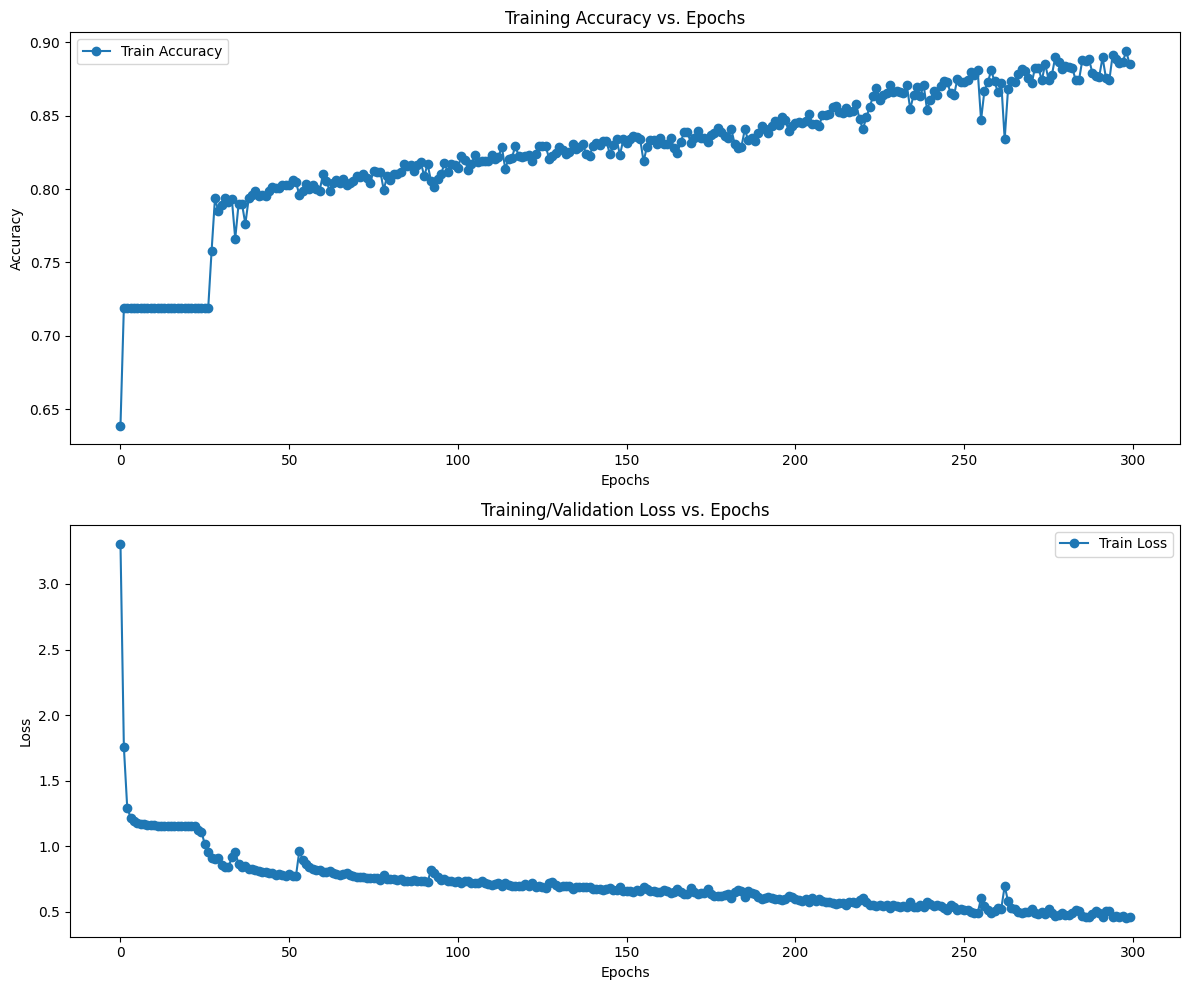

In [14]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

plt.tight_layout()
plt.show()

In [15]:
predictions = newmodel.predict(X_test)

In [18]:
y_pred = np.argmax(predictions, axis=1)
y_true =np.argmax(y_test,axis=1)
print(y_pred)
print(y_true)

[ 3  3  3  4  3  4  3  3  3  3  3  3  3  3  4  3  3  3  3  3  3  3  3  3
  3  3  3  4  3  3  3  3  3  3  3  3  3  3  3  4  3  3  3  3  3  1  3 19
  3  3 20  3  3  3  3 20  3  3  3  3  3  3  3  4  4  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  4  3  4  3  3  3  3  3  4  3
  3  4  3  3  3  3  3  3  4  3  3  3  3 20  4  3  3  3  3  3  3  3  3  4
  3  3  3  4  4  4 20  3  3  3  3  4  3  4  3  3  3  3  3  3  3  3  3  4
 19  4  3  3  3  3  3  4  3  3  3  4  3  3  3  3  3  3  3  3  3  3  4  4
  3  3  3  3 19  3  6  3  3  4  3  3  3  4  3  3  3  4  3  4  3  3 20  3
  3  4  4 19  3  1  3  3 20  4  3  3 19  3  3  3  3  3  4  3  3  3 20 19
  4 20  3  3  4  3  3 19  3  3  3  1  3  3  3  3  3 20  3  3  3  3  3  3
  4 20  3 19 19  1  4  3  3  3  3  4  3  3  3  3  3  3  3  3  3  4  3  3
  3  3  4  3  1  3  3  3  3  3  3  4  3  3  3  4  4  3  3  3  4  3  3  3
  3  3  4  4  3  3  4  3  3  4  3  3  3  3  3  3  3  4  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3 19  4  3  3

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

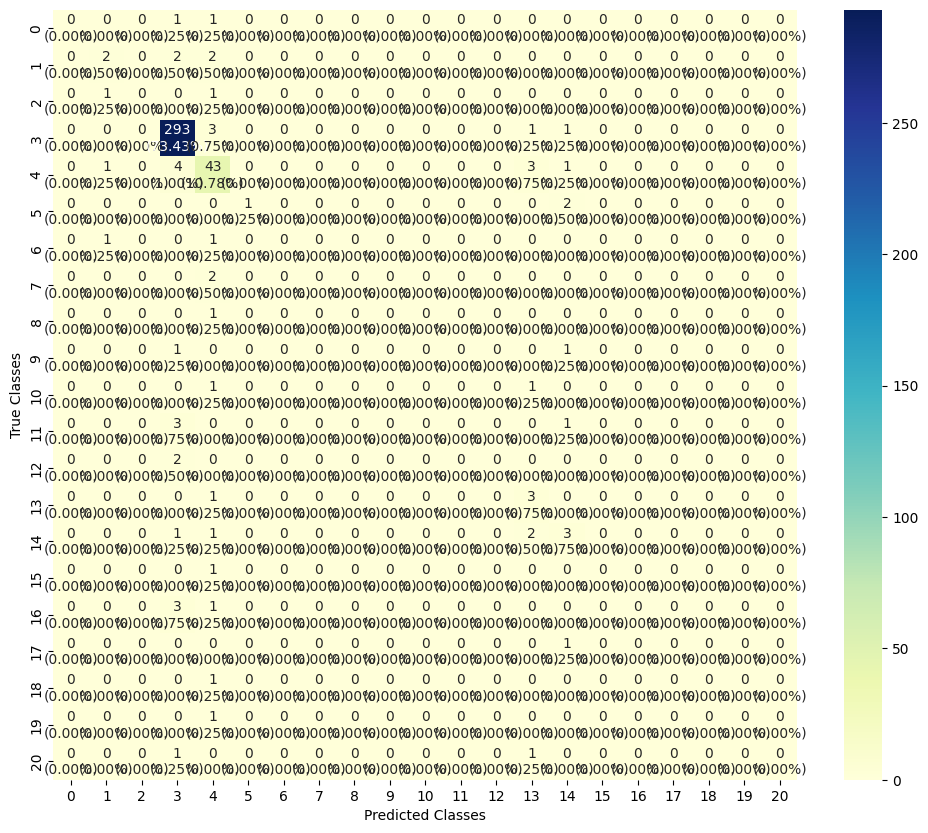

In [22]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
cf_mtx = confusion_matrix(y_true, y_pred)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(21,21)

plt.figure(figsize = (12, 10))
sns.heatmap(cf_mtx, 
           cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

In [3]:
import os
os.listdir('save/3200105974')

['assets',
 'gan_fashion-mnist_tf50.h5',
 'gan_fashion-mnist_tf15.h5',
 'gan_fashion-mnist_tf20.h5',
 'saved_model.pb',
 'model.h5',
 'gan_fashion-mnist_tf45.h5',
 'cnn_model.h5',
 'variables',
 'gan_fashion-mnist_tf30.h5',
 'bestmodel.h5',
 'testdir',
 'gan_fashion-mnist_tf25.h5',
 'gan_fashion-mnist_tf10.h5',
 'gan_fashion-mnist_tf35.h5',
 'keras_metadata.pb',
 'gan_fashion-mnist_tf40.h5',
 'gan_fashion-mnist_tf5.h5']

#### 总结说明
此处说明关于模型设计与模型训练（参数设置、训练和调优过程）的心得与总结

### 心得总结

划分出的数据集中，序号3占比过大，可能造成模型倾向于分类为序号3的结果。模型训练的前期有一段accuracy保持0.717，也是这一原因。
#### 模型设计：
理解问题：在设计模型之前，要充分理解问题的背景和要解决的任务。这包括了对数据的认知、预期的输出以及评估指标等。
架构选择：选择适当的模型架构，如卷积神经网络（CNN）适用于图像数据，循环神经网络（RNN）适用于序列数据等。可以参考先前的研究和经验，但也要考虑问题的特定需求。
注意力机制：注意力机制通过学习权重或分数，使模型能够根据输入的不同部分赋予不同的重要性。

#### 参数设置：
学习率：学习率决定了每次参数更新的步长。选择一个合适的学习率对于模型的收敛和性能至关重要。可以尝试不同的学习率，并观察模型在训练集上的损失和验证集上的性能，选择一个合适的值。
批量大小：批量大小决定了每次参数更新时使用的样本数量。较大的批量大小可以提高训练速度，但可能降低模型的泛化能力。根据内存和计算资源的限制，选择适当的批量大小。
#### 模型训练：
数据预处理：对输入数据进行预处理是很重要的。这可能包括数据归一化、特征缩放、标签编码等。确保数据的质量和一致性。
迭代次数：选择合适的迭代次数进行训练。如果模型在训练集上的性能持续提升而在验证集上停滞，可能出现过拟合的情况。可以使用早停法来防止过拟合。

最后，模型设计和调优是一个迭代的过程。通过尝试不同的架构、参数和技术，不断优化模型，直到达到预期的性能。同时，持续学习和关注最新的研究和技术进展，也可以帮助提高模型设计和调优的能力。